# Kudi Gaussian IRC tutorial

**Section 0 — Overview**

Kudi parses Gaussian IRC outputs to expose reaction coordinates, energies, geometries, molecular orbitals, and NBO-derived properties along the intrinsic reaction coordinate. This tutorial walks through the full `output_sp.dat` IRC fixture (a long trajectory with many blocks) and demonstrates how to interrogate the parsed data.

We will cover:
- loading the IRC file into a reusable `IRCPath` object
- inspecting basic counts, reaction coordinates, and energies
- checking data alignment and block structure
- plotting energetics and structural metrics
- accessing geometries, orbitals, and NBO-derived properties
- performing a light derived analysis and saving selected results

## Section 1 — Environment and Imports

In [1]:
from pathlib import Path
import sys
import platform

# Ensure the source tree is importable even when an older namespace package is present.
tutorial_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()
if tutorial_dir.name != "tutorials":
    candidate = tutorial_dir / "tutorials"
    if candidate.exists():
        tutorial_dir = candidate

src_path = tutorial_dir.parent / "src"
if src_path.exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import kudi
from kudi import IRCPath

python_version = platform.python_version()
print(f"Python version: {python_version}")
print(f"kudi imported, __version__={getattr(kudi, '__version__', 'unknown')}")


Python version: 3.11.14
kudi imported, __version__=0.3.0


## Section 2 — Load the IRC file

In [10]:
irc_file = tutorial_dir / "output_sp_mol_prop.dat"
if not irc_file.exists():
    raise FileNotFoundError(f"Expected IRC file at {irc_file}")

irc_path = IRCPath.from_file(irc_file)

rx_values = [rx for rx in irc_path.rx_coords if rx is not None]
energy_values = [e for e in irc_path.energies_hartree if e is not None]

point_count = len(irc_path.points)
rx_min, rx_max = (min(rx_values), max(rx_values)) if rx_values else (None, None)
energy_min, energy_max = (min(energy_values), max(energy_values)) if energy_values else (None, None)

print(f"Parsed {point_count} IRC points from {irc_file.name}")
print(f"Reaction coordinate range: {rx_min} to {rx_max}")
print(f"Energy (Hartree) range: {energy_min} to {energy_max}")

try:
    import pandas as pd
except ImportError:  # pragma: no cover - pandas is optional for display
    pd = None

if pd:
    preview_df = pd.DataFrame(
        {
            "index": range(point_count),
            "reaction_coordinate": irc_path.rx_coords,
            "energy_hartree": irc_path.energies_hartree,
        }
    )
    display(preview_df.head(5))
else:
    print("pandas not installed; skipping tabular preview.")


Parsed 91 IRC points from output_sp_mol_prop.dat
Reaction coordinate range: -2.61141 to 2.08819
Energy (Hartree) range: -528.440683278 to -528.394888232
pandas not installed; skipping tabular preview.


## Section 3 — IRC segmentation and sanity checks

In [11]:
n_rx = len(irc_path.rx_coords)
n_energy = len(irc_path.energies_hartree)
print(f"Reaction coordinates stored: {n_rx}")
print(f"Energies stored: {n_energy}")
print(f"Geometries stored: {sum(1 for g in irc_path.geometries if g)}")

if rx_values:
    print(f"First reaction coordinate: {rx_values[0]}")
    print(f"Last reaction coordinate: {rx_values[-1]}")

alignment_ok = n_rx == n_energy == point_count
print(f"Length alignment (rx vs energy vs points): {alignment_ok}")


Reaction coordinates stored: 91
Energies stored: 91
Geometries stored: 91
First reaction coordinate: 2.08819
Last reaction coordinate: -2.61141
Length alignment (rx vs energy vs points): True


## Section 4 — Energetics along the IRC

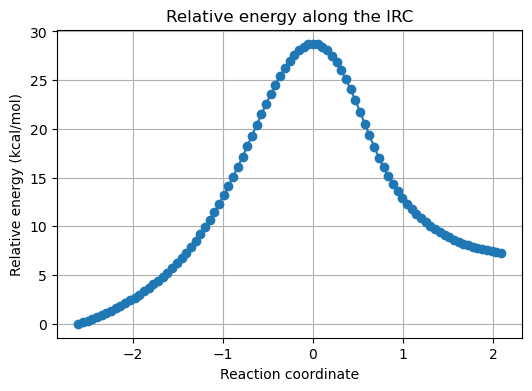

In [12]:
import matplotlib.pyplot as plt

relative_kcal = irc_path.relative_energies_kcal(reference="min_rx") if energy_values else []

energy_df = None
if 'pd' in globals() and pd:
    energy_df = pd.DataFrame(
        {
            "reaction_coordinate": irc_path.rx_coords,
            "energy_hartree": irc_path.energies_hartree,
            "relative_kcal_mol": relative_kcal or [None] * point_count,
        }
    )
    display(energy_df.head(10))

if rx_values and relative_kcal:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rx_values, relative_kcal, marker="o", linestyle="-", color="tab:blue")
    ax.set_title("Relative energy along the IRC")
    ax.set_xlabel("Reaction coordinate")
    ax.set_ylabel("Relative energy (kcal/mol)")
    ax.grid(True)
    plt.show()
else:
    print("Energy values unavailable for plotting.")


## Section 5 — Geometry access and molecular properties

In [13]:
import numpy as np

geom0 = irc_path.geometries[0] if irc_path.geometries else None
if geom0:
    atom_table = [
        {"index": idx, "symbol": atom.symbol, "x": atom.x, "y": atom.y, "z": atom.z}
        for idx, atom in enumerate(geom0.atoms)
    ]
    if 'pd' in globals() and pd:
        display(pd.DataFrame(atom_table))
    else:
        for row in atom_table:
            print(row)
else:
    print("No geometry available to preview.")


def distance(geometry, i, j):
    a, b = geometry.atoms[i], geometry.atoms[j]
    return float(np.linalg.norm(np.array([a.x, a.y, a.z]) - np.array([b.x, b.y, b.z])))


def angle(geometry, i, j, k):
    a, b, c = [np.array([atom.x, atom.y, atom.z]) for atom in (geometry.atoms[i], geometry.atoms[j], geometry.atoms[k])]
    v1, v2 = a - b, c - b
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return float(np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0))))


def dihedral(geometry, i, j, k, l):
    p0, p1, p2, p3 = [np.array([atom.x, atom.y, atom.z]) for atom in (geometry.atoms[i], geometry.atoms[j], geometry.atoms[k], geometry.atoms[l])]
    b0, b1, b2 = p0 - p1, p2 - p1, p3 - p2
    b1 /= np.linalg.norm(b1)
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return float(np.degrees(np.arctan2(y, x)))

bond_indices = (0, 4)  # Example: C(0)-F(4)
angle_indices = (1, 0, 4)  # Example: H(1)-C(0)-F(4)
dihedral_indices = (1, 0, 4, 5)  # H(1)-C(0)-F(4)-F(5)

bond_lengths = []
angles = []
dihedrals = []
for geom in irc_path.geometries:
    if geom:
        bond_lengths.append(distance(geom, *bond_indices))
        angles.append(angle(geom, *angle_indices))
        dihedrals.append(dihedral(geom, *dihedral_indices))
    else:
        bond_lengths.append(None)
        angles.append(None)
        dihedrals.append(None)

if pd:
    preview_geom = pd.DataFrame(
        {
            "reaction_coordinate": irc_path.rx_coords,
            "C0-F4_distance": bond_lengths,
            "H1-C0-F4_angle": angles,
            "H1-C0-F4-F5_dihedral": dihedrals,
        }
    )
    display(preview_geom.head(10))

if rx_values:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rx_values, bond_lengths[: len(rx_values)], color="tab:green")
    ax.set_title("C–F bond distance along the IRC")
    ax.set_xlabel("Reaction coordinate")
    ax.set_ylabel("Distance (Å)")
    ax.grid(True)
    plt.show()


{'index': 0, 'symbol': 'H', 'x': 1.591925, 'y': -0.29481, 'z': 0.0}
{'index': 1, 'symbol': 'S', 'x': -0.774618, 'y': -0.649238, 'z': 0.0}
{'index': 2, 'symbol': 'N', 'x': 0.0, 'y': 0.755681, 'z': 0.0}
{'index': 3, 'symbol': 'O', 'x': 1.350246, 'y': 0.674106, 'z': 0.0}


IndexError: list index out of range

## Section 6 — Molecular orbital properties

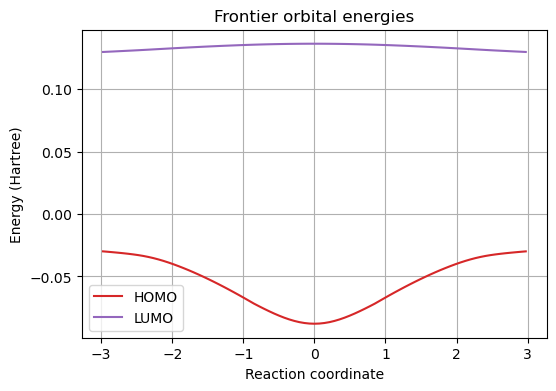

In [6]:
homo = []
lumo = []
for occ, virt in zip(irc_path.occ_orbitals, irc_path.virt_orbitals):
    homo.append(max(occ) if occ else None)
    lumo.append(min(virt) if virt else None)

if any(v is not None for v in homo) and any(v is not None for v in lumo):
    if pd:
        mo_df = pd.DataFrame(
            {
                "reaction_coordinate": irc_path.rx_coords,
                "HOMO_energy": homo,
                "LUMO_energy": lumo,
            }
        )
        display(mo_df.head(10))

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rx_values, homo[: len(rx_values)], label="HOMO", color="tab:red")
    ax.plot(rx_values, lumo[: len(rx_values)], label="LUMO", color="tab:purple")
    ax.set_title("Frontier orbital energies")
    ax.set_xlabel("Reaction coordinate")
    ax.set_ylabel("Energy (Hartree)")
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print("Molecular orbital energies are not available in this dataset.")


## Section 7 — NBO: natural charges

In [ ]:
charges_by_atom = irc_path.nbo_charges()
if charges_by_atom:
    first_atom = sorted(charges_by_atom)[0]
    charges = charges_by_atom[first_atom]
    if pd:
        charge_df = pd.DataFrame(
            {
                "reaction_coordinate": irc_path.rx_coords,
                f"charge({first_atom})": charges,
            }
        )
        display(charge_df.head(10))

    valid_rx = [rx for rx, val in zip(irc_path.rx_coords, charges) if rx is not None and val is not None]
    valid_charge = [val for rx, val in zip(irc_path.rx_coords, charges) if rx is not None and val is not None]

    if valid_rx:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(valid_rx, valid_charge, marker="o", linestyle="-", color="tab:orange")
        ax.set_title(f"Natural charge for {first_atom}")
        ax.set_xlabel("Reaction coordinate")
        ax.set_ylabel("Charge (e)")
        ax.grid(True)
        plt.show()
else:
    print("No NBO charge data were parsed for this IRC; missing values are expected if NBO was not printed in every block.")


## Section 8 — NBO: Wiberg bond orders

In [ ]:
wiberg = irc_path.wiberg_bond_orders()
if wiberg:
    first_bond = sorted(wiberg)[0]
    bond_orders = wiberg[first_bond]
    if pd:
        wbo_df = pd.DataFrame(
            {
                "reaction_coordinate": irc_path.rx_coords,
                f"Wiberg({first_bond})": bond_orders,
            }
        )
        display(wbo_df.head(10))

    valid_rx = [rx for rx, val in zip(irc_path.rx_coords, bond_orders) if rx is not None and val is not None]
    valid_wbo = [val for rx, val in zip(irc_path.rx_coords, bond_orders) if rx is not None and val is not None]

    if valid_rx:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(valid_rx, valid_wbo, color="tab:brown")
        ax.set_title(f"Wiberg bond order for {first_bond}")
        ax.set_xlabel("Reaction coordinate")
        ax.set_ylabel("Bond order")
        ax.grid(True)
        plt.show()

        if valid_wbo:
            delta = max(valid_wbo) - min(valid_wbo)
            print(f"Bond order variation across the IRC for {first_bond}: {delta:.3f}")
else:
    print("No Wiberg bond order data were parsed; this often occurs when NBO output is absent for a point.")


## Section 9 — Derived analyses

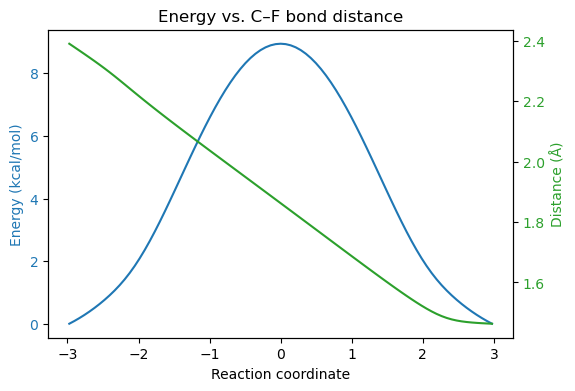

In [7]:
if rx_values and relative_kcal and bond_lengths:
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(rx_values, relative_kcal, color="tab:blue", label="Relative energy")
    ax1.set_xlabel("Reaction coordinate")
    ax1.set_ylabel("Energy (kcal/mol)", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(rx_values, bond_lengths[: len(rx_values)], color="tab:green", label="C–F distance")
    ax2.set_ylabel("Distance (Å)", color="tab:green")
    ax2.tick_params(axis='y', labelcolor='tab:green')

    plt.title("Energy vs. C–F bond distance")
    plt.show()
else:
    print("Insufficient data for derived analysis plot.")


### Derived IRC quantities

The API exposes reaction force, reaction force constant, Koopmans chemical potential, and flux as arrays aligned with the reaction coordinate. These values can be plotted directly from notebooks without additional file I/O.


In [8]:
force_data = irc_path.reaction_force()
kappa_data = irc_path.reaction_force_constant()
mu_data = irc_path.chemical_potential_koopmans()
flux_data = irc_path.flux()

rx_numeric = force_data['reaction_coordinate']
reaction_force = force_data['reaction_force']
reaction_force_constant = kappa_data['reaction_force_constant']
chemical_potential = mu_data['chemical_potential']
flux = flux_data['flux']


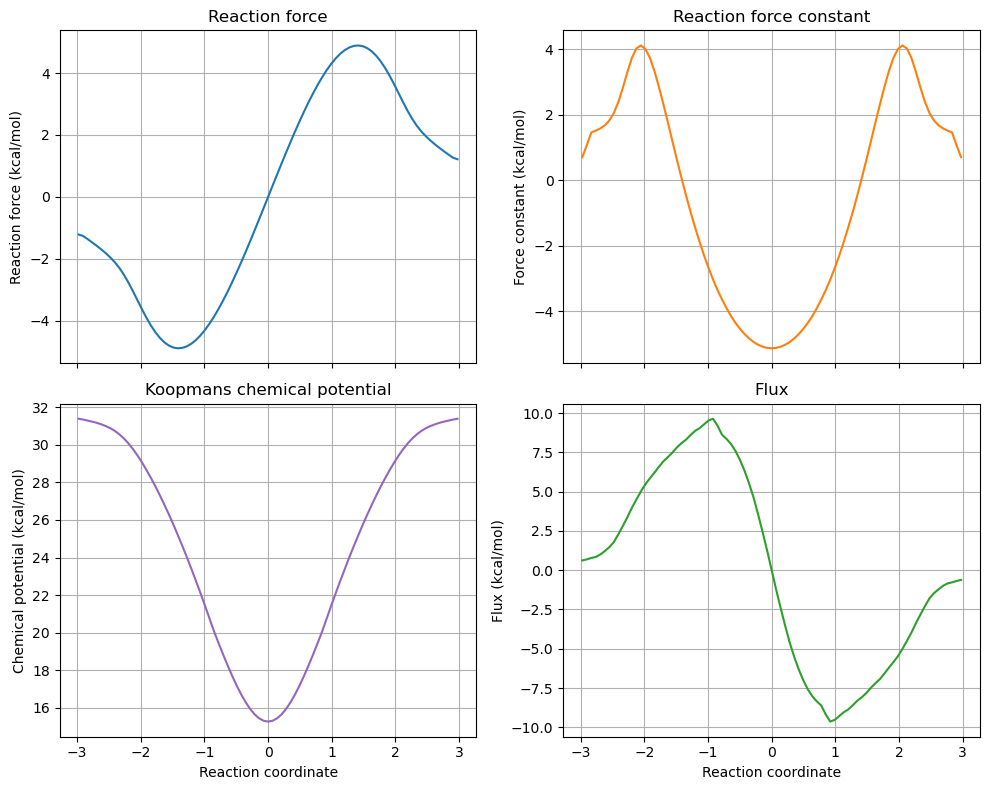

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes[0, 0].plot(rx_numeric, reaction_force, color='tab:blue')
axes[0, 0].set_ylabel('Reaction force (kcal/mol)')
axes[0, 0].set_title('Reaction force')

axes[0, 1].plot(rx_numeric, reaction_force_constant, color='tab:orange')
axes[0, 1].set_ylabel('Force constant (kcal/mol)')
axes[0, 1].set_title('Reaction force constant')

axes[1, 0].plot(rx_numeric, chemical_potential, color='tab:purple')
axes[1, 0].set_xlabel('Reaction coordinate')
axes[1, 0].set_ylabel('Chemical potential (kcal/mol)')
axes[1, 0].set_title('Koopmans chemical potential')

axes[1, 1].plot(rx_numeric, flux, color='tab:green')
axes[1, 1].set_xlabel('Reaction coordinate')
axes[1, 1].set_ylabel('Flux (kcal/mol)')
axes[1, 1].set_title('Flux')

for ax in axes.ravel():
    ax.grid(True)

fig.tight_layout()
plt.show()


## Section 10 — Export / saving results

In [ ]:
if 'pd' in globals() and pd and rx_values and relative_kcal and bond_lengths:
    export_df = pd.DataFrame(
        {
            "reaction_coordinate": rx_values,
            "relative_energy_kcal_mol": relative_kcal,
            "C0_F4_distance": bond_lengths[: len(rx_values)],
        }
    )
    export_path = tutorial_dir / "irc_summary.csv"
    export_df.to_csv(export_path, index=False)
    print(f"Saved a compact summary to {export_path.relative_to(tutorial_dir.parent)}")
else:
    print("Export skipped (requires pandas and parsed data).")


## Section 11 — Summary and next steps

- Parsed the full Gaussian IRC output once and reused the resulting `IRCPath` object throughout.
- Inspected reaction coordinates, energies, and geometries, confirming array alignment.
- Visualized relative energetics, frontier orbitals, and a representative C–F bond length.
- Demonstrated access patterns for NBO charges and Wiberg bond orders with graceful handling of missing data.
- Correlated energy changes with bond length variations and saved a compact CSV summary.

For further exploration, review the `IRCPath` API in `src/kudi/analysis/irc_path.py` and the accompanying parsers in `src/kudi/parsing/`. The automated tests in `tests/` provide additional usage examples.
